In [13]:
from utils.load_dataset import PlantVillageDataset
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import cv2
from utils.preprocessing import preprocessing_img
import numpy as np
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, InceptionResNetV2
import torchvision.models  as models
from torchvision import transforms

In [18]:
# Load the dataset
PATH = './Plant_leave_diseases_dataset_without_augmentation'
transform = transforms.Compose([
    preprocessing_img,
    transforms.ToTensor(),
])
training_data = PlantVillageDataset(PATH, img_mode="LAB", train=True, transform=transform)
test_data = PlantVillageDataset(PATH, img_mode="LAB", train=False, transform=transform)

TypeError: Invalid shape (3, 224, 224) for image data

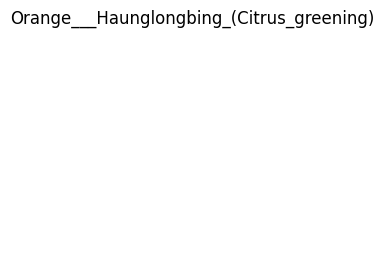

In [19]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(list(training_data.label_to_idx.keys())[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [20]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [21]:
resnet50v2 = models.resnet50(weights='ResNet50_Weights.DEFAULT')
efficientnet_b0 = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
efficientnet_b3 = models.efficientnet_b3(weights='EfficientNet_B3_Weights.DEFAULT')
densenet = models.densenet121(weights='DenseNet121_Weights.DEFAULT')

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
resnet50v2 = resnet50v2.to(device)
efficientnet_b0 = efficientnet_b0.to(device)
efficientnet_b3 = efficientnet_b3.to(device)
densenet = densenet.to(device)

In [25]:
resnet50v2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# Linear Model
import torch.nn as nn
class LinearHeadModel(nn.Module):
    
    def __init__(self, input_dim, output_dim, dropout_rate=0.25):
        super(LinearHeadModel, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.batch_norm = nn.BatchNorm1d(input_dim)
        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.Dropout(dropout_rate),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.batch_norm(x)
        x = self.linear_layers(x)
        return x

In [25]:
def train_model(pre_trained_model, linear_model, train_loader, criterion, optimizer, epochs=50):
    linear_model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs_pre_trained = pre_trained_model(inputs)
            outputs = linear_model(outputs_pre_trained)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

In [7]:
training_data[3171][0].shape

(224, 224, 3)

In [26]:
resnet_linear_block = LinearHeadModel(1000, 38)
train_model(resnet50v2, resnet_linear_block, train_dataloader, nn.CrossEntropyLoss(), torch.optim.Adam(resnet50v2.parameters(), lr=0.001))

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000019BBFC03E50>>
Traceback (most recent call last):
  File "c:\Users\tlc29\Documents\CS\3A\Deep Learning\DL\lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
KeyboardInterrupt: 


ValueError: Input dimension should be at least 3